In [3]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import io
import seaborn as sns
from IPython.display import Image
pd.set_option('display.max_rows', 15)
pd.options.display.float_format = '{:.8f}'.format

# NOMIS CASE STUDY

### Objective
Help eCar transition to a data analytics based pricing strategy that allows them to maximize profits by 
1. **increasing the number of loan applicants that accept an autolone offer once offered
2. **identifying the maximum loan interest rate that could be offered to customers.

The dataset is historical data of the details of loans and customer vs. customes' decision whether to accept the loan or not.

There are 3 main sections in this notebook which are..
1. Data Exploratory
2. Building a model without customer segmentation
3. Building a model with customer segmentation (by clustering)

# Data Exploratory

In [45]:
#load loans data
nomis = pd.read_csv('https://drive.google.com/uc?export=download&id=10Sc5biMoOHsRxg1GH7AXS9EVAwYglZHB')
nomis = nomis.drop('Approve Date',1)
nomis['Previous Rate'] = nomis['Previous Rate'].fillna('0.0')
nomis = nomis.dropna()
nomis['Previous Rate'] = nomis['Previous Rate'].replace(' ','0.0').apply(lambda x: float(x))

nomis.head(5)

,Tier,FICO,Term,Amount,Previous Rate,Car Type,Competition rate,Outcome,Rate,Cost of Funds,Partner Bin
0,3,695,72,35000.00000000,0.00000000,N,6.25000000,0,7.49000000,1.83880000,1
1,1,751,60,40000.00000000,0.00000000,N,5.65000000,0,5.49000000,1.83880000,3
2,1,731,60,18064.00000000,0.00000000,N,5.65000000,0,5.49000000,1.83880000,3
3,4,652,72,15415.00000000,0.00000000,N,6.25000000,0,8.99000000,1.83880000,3
4,1,730,48,32000.00000000,0.00000000,N,5.65000000,0,5.49000000,1.83880000,1


Text(0, 0.5, '# Users')

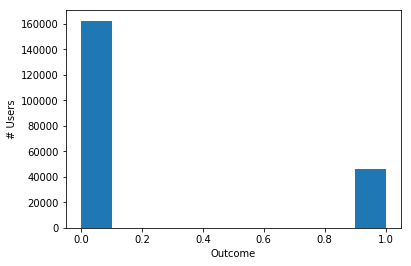

In [47]:
# Check the balance and baseline of the model

plt.hist(nomis.Outcome)
plt.xlabel('Outcome')
plt.ylabel('# Users')

# project is slightly unbalanced

In [48]:
# Baseline
print(nomis.Outcome.value_counts())
print('Baseline: ', nomis.Outcome.value_counts()[0]/len(nomis))

0    162298
1     45787
Name: Outcome, dtype: int64
Baseline:  0.7799601124540452


The outcome is unbalanced. There are more customers who rejected loan offers

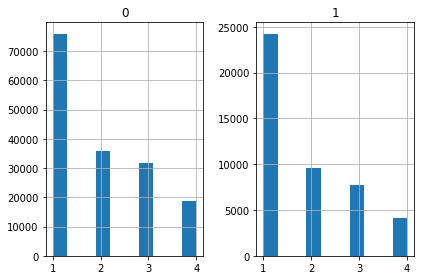

In [49]:
nomis.dropna().pivot(columns='Outcome', values='Tier').hist()
plt.tight_layout()

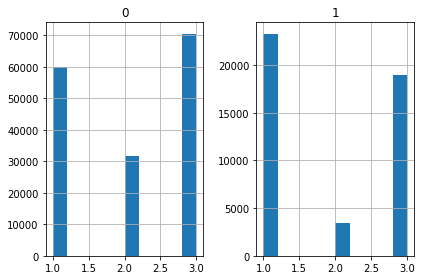

In [50]:
nomis.dropna().pivot(columns='Outcome', values='Partner Bin').hist()
plt.tight_layout()

median  [5.09 5.15 5.09]
mean  [5.63861875 5.52574961 5.64678859]


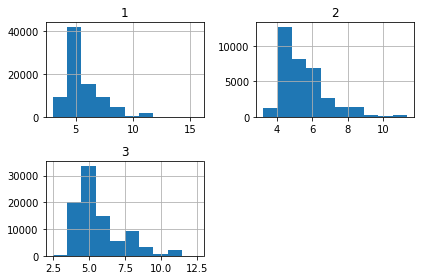

In [51]:
nomis.dropna().pivot(columns='Partner Bin', values='Rate').hist()

plt.tight_layout()
print('median ',np.nanmedian(nomis.dropna().pivot(columns='Partner Bin', values='Rate'),0))
print('mean ', np.nanmean(nomis.dropna().pivot(columns='Partner Bin', values='Rate'),0))

Index(['Tier', 'FICO', 'Term', 'Amount', 'Previous Rate', 'Car  Type',
       'Competition rate', 'Outcome', 'Rate', 'Cost of Funds', 'Partner Bin'],
      dtype='object')

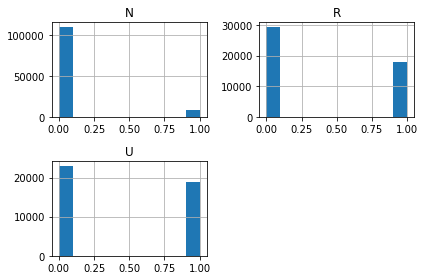

In [52]:
nomis.dropna().pivot(columns='Car  Type', values='Outcome').hist()

plt.tight_layout()
nomis.columns

In [53]:
nomis['Previous Rate'] = nomis['Previous Rate'].replace(' ','0.0').apply(lambda x: float(x))
nomis['Previous Rate'].head(10)

0   0.00000000
1   0.00000000
2   0.00000000
3   0.00000000
4   0.00000000
5   0.00000000
6   0.00000000
7   0.00000000
8   0.00000000
9   0.00000000
Name: Previous Rate, dtype: float64

In [54]:
nomis.isna().sum()

Tier                0
FICO                0
Term                0
Amount              0
Previous Rate       0
Car  Type           0
Competition rate    0
Outcome             0
Rate                0
Cost of Funds       0
Partner Bin         0
dtype: int64

In [55]:
nomis.dtypes

Tier                  int64
FICO                  int64
Term                  int64
Amount              float64
Previous Rate       float64
Car  Type            object
Competition rate    float64
Outcome               int64
Rate                float64
Cost of Funds       float64
Partner Bin           int64
dtype: object

# Building a model without customer segmentation

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier 
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.metrics import roc_auc_score
import sklearn.metrics
import sklearn.model_selection
import graphviz
import statsmodels.api as sm
import statsmodels.formula.api as smf

import xgboost as xgb

def DrawConfusionMatrix(confusion_matrix):
  # Taken from https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
  class_names = ['no loan', 'loan']
  df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
  fig = plt.figure(figsize=(4, 3))
  heatmap = sns.heatmap(df_cm, annot=True, fmt='d')
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), ha='center')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.title('Confusion Matrix')
  plt.show()

def SensitivityAndSpecificity(cm):
  # True positives are in the lower-right (row 1, column 1)
  TP = cm[1, 1]
  # True negatives are in the upper-left (row 0, column 0)
  TN = cm[0, 0]
  # False positives are in the upper-right (row 0, columns 1)
  FP = cm[0, 1]
  # False negatives are in the lower-left (row 1, column 0)
  FN = cm[1, 0]
  sensitivity = TP / (TP + FN)
  specificity = TN / (TN + FP)
  precision = TP / (TN + TP)
  print('Accuracy: ', (TP+TN)/(TP+TN+FP+FN))
  print('Sensitivity (Recall): ', sensitivity, ', Specificity (1-FPR): ', specificity)
  print('Precision: ', precision, ', F1-Score: ', 2 * precision*sensitivity / (precision+sensitivity) )
  
  return {'Sensitivity': sensitivity, 'Specificity': specificity}

In [0]:
# Create binary variables for car types
nomis = pd.concat([nomis,pd.get_dummies(nomis['Car  Type'])],axis=1)
nomis = nomis.drop('Car  Type',1)

# Tier is not continuous variable. -> convert to object
nomis = pd.concat([nomis,pd.get_dummies(nomis['Tier'])],axis=1)
nomis = nomis.drop('Tier',1)

In [58]:
nomis.head()

,FICO,Term,Amount,Previous Rate,Competition rate,Outcome,Rate,Cost of Funds,Partner Bin,N,R,U,1,2,3,4
0,695,72,35000.00000000,0.00000000,6.25000000,0,7.49000000,1.83880000,1,1,0,0,0,0,1,0
1,751,60,40000.00000000,0.00000000,5.65000000,0,5.49000000,1.83880000,3,1,0,0,1,0,0,0
2,731,60,18064.00000000,0.00000000,5.65000000,0,5.49000000,1.83880000,3,1,0,0,1,0,0,0
3,652,72,15415.00000000,0.00000000,6.25000000,0,8.99000000,1.83880000,3,1,0,0,0,0,0,1
4,730,48,32000.00000000,0.00000000,5.65000000,0,5.49000000,1.83880000,1,1,0,0,1,0,0,0


In [59]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(nomis.drop('Outcome',1), nomis.Outcome, test_size=0.2)
nomis.dtypes

FICO                  int64
Term                  int64
Amount              float64
Previous Rate       float64
Competition rate    float64
Outcome               int64
Rate                float64
                     ...   
N                     uint8
R                     uint8
U                     uint8
1                     uint8
2                     uint8
3                     uint8
4                     uint8
Length: 16, dtype: object

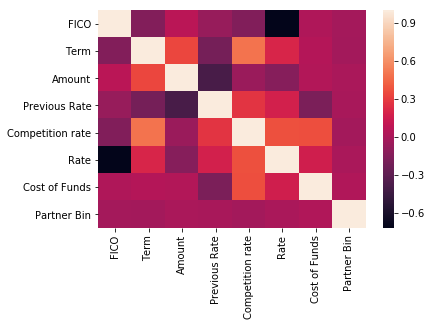

In [60]:
#  Check the Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train.drop(['N','R','U',1.0,2.0,3.0,4.0],1).values, i) for i in range(X_train.drop(['N','R','U',1.0,2.0,3.0,4.0],1).shape[1])]
vif["features"] = X_train.drop(['N','R','U',1.0,2.0,3.0,4.0],1).columns
vif

# calculate the correlation matrix
corr = X_train.drop(['N','R','U',1.0,2.0,3.0,4.0],1).corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [61]:
# from previous graph, drop Previous Rate .
vif = pd.DataFrame()
X = X_train.drop(['Competition rate','FICO','Term'],1)

vif["VIF Factor"] = [variance_inflation_factor(X.drop(['N','R','U',1.0,2.0,3.0,4.0],1).values, i) for i in range(X.drop(['N','R','U',1.0,2.0,3.0,4.0],1).shape[1])]
vif["features"] = X.drop(['N','R','U',1.0,2.0,3.0,4.0],1).columns
vif

,VIF Factor,features
0,6.11937602,Amount
1,1.46203170,Previous Rate
2,12.67678063,Rate
3,15.60327925,Cost of Funds
4,5.43125197,Partner Bin


In [62]:
# Logistic regression
X = X.drop(['N','R','U',1.0,2.0,3.0,4.0],1)
X_train_log = sm.tools.add_constant(X)
logreg_fit = smf.GLM(Y_train, X_train_log,
                     family=sm.families.Binomial()).fit()
display(logreg_fit.summary())

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                Outcome   No. Observations:               166468
Model:                            GLM   Df Residuals:                   166462
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -74159.
Date:                Fri, 10 May 2019   Deviance:                   1.4832e+05
Time:                        03:55:09   Pearson chi2:                 3.11e+05
No. Iterations:                     6   Covariance Type:             nonrobust
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.7662      0.044     39.812      0.000       1.679       1.853
Amount        -9.781e-05   8.29e-07   -118.048      0.000   -9.94e-05   -9.62e-05
Previous Rate     0.0564      0.002     32.532      0.000       0.053       0.060
Rate             -0.1473      0.005    -32.708      0.000      -0.156      -0.138
Cost of Funds     0.2472      0.024     10.327      0.000       0.200       0.294
Partner Bin      -0.2120      0.007    -30.164      0.000      -0.226      -0.198
=================================================================================
"""

In [63]:
#@title Predict
logreg_predicted_train = logreg_fit.predict(
    sm.tools.add_constant(X))
logreg_predicted_test  = logreg_fit.predict(
    sm.tools.add_constant(X_test.drop(['N','R','U',1.0,2.0,3.0,4.0,'Competition rate','FICO','Term'],1)))


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


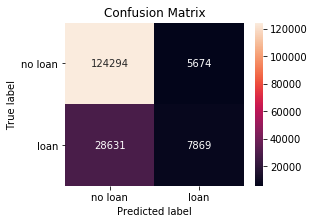

Accuracy:  0.7939243578345387
Sensitivity (Recall):  0.21558904109589042 , Specificity (1-FPR):  0.9563430998399606
Precision:  0.059540113344884724 , F1-Score:  0.09331032888066737


{'Sensitivity': 0.21558904109589042, 'Specificity': 0.9563430998399606}

In [64]:
logreg_cm_train = sklearn.metrics.confusion_matrix(
    Y_train, logreg_predicted_train > 0.5)
DrawConfusionMatrix(logreg_cm_train)
SensitivityAndSpecificity(logreg_cm_train)

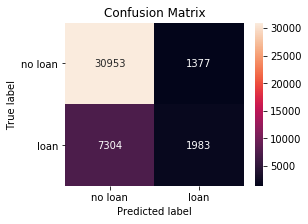

Accuracy:  0.7914073575702237
Sensitivity (Recall):  0.21352428125336492 , Specificity (1-FPR):  0.9574079802041447
Precision:  0.060207675491863004 , F1-Score:  0.09392984866068256


{'Sensitivity': 0.21352428125336492, 'Specificity': 0.9574079802041447}

In [65]:
logreg_cm_test = sklearn.metrics.confusion_matrix(
    Y_test, logreg_predicted_test > 0.5)
DrawConfusionMatrix(logreg_cm_test)
SensitivityAndSpecificity(logreg_cm_test)

In [0]:
from sklearn.model_selection import KFold

features = X_train.columns

def GetDecisionTreeGraphViz(dt):
  from IPython.display import Image
  return graphviz.Source(sklearn.tree.export_graphviz(
      dt, out_file=None, filled=True, impurity=False,
      feature_names=features,
      class_names=['takes loan', 'otherwise']))

def getthebestdepth(dep):
  import numpy as np
  train_errors = np.zeros([dep, 5])
  valid_errors = np.zeros([dep, 5])
  
  # 5-fold cross validation
  kf = KFold(n_splits=5) 
  kf.get_n_splits(X_train)
  fold_index = 0
  for train_index, test_index in kf.split(X_train):
    X_training, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
    Y_training, Y_val = Y_train.iloc[train_index], Y_train.iloc[test_index]

    for d in range(1,dep+1):
#       print(d, fold_index)
      dt = sklearn.tree.DecisionTreeClassifier(max_depth=d,random_state=7)
      dt.fit(X_training, Y_training)
      train_errors[d-1, fold_index] = 1 - dt.score(X_training, Y_training)
      valid_errors[d-1, fold_index] = 1 - dt.score(X_val, Y_val)
    fold_index += 1
  mean_train_error = np.mean(train_errors,1)
  mean_valid_error = np.mean(valid_errors,1)
  plt.plot(range(1,dep+1), mean_train_error, label='Mean Training Error')
  plt.plot(range(1,dep+1), mean_valid_error, label='Mean Validation Error')
  plt.xlabel('Max Tree Depth')
  plt.ylabel('Error (higher is better)')
  plt.legend()
  plt.show()

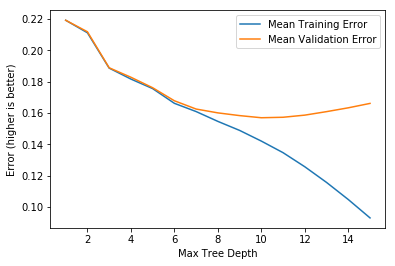

In [67]:
getthebestdepth(15)

In [68]:
dt = sklearn.tree.DecisionTreeClassifier(max_depth=10,random_state=7)
dt.fit(X_train, Y_train)
display(Image(GetDecisionTreeGraphViz(dt).pipe(format='png'), width=900))

Output hidden; open in https://colab.research.google.com to view.

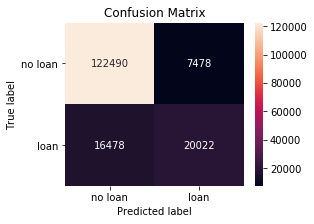

Accuracy:  0.8560924622149603
Sensitivity (Recall):  0.5485479452054794 , Specificity (1-FPR):  0.9424627600640157
Precision:  0.140493432132031 , F1-Score:  0.22369450092731213


In [69]:
predicted_train = dt.predict(X_train)

pred_train_dt = sklearn.metrics.confusion_matrix(
    Y_train, predicted_train > 0.5)
DrawConfusionMatrix(pred_train_dt)
_ =SensitivityAndSpecificity(pred_train_dt)

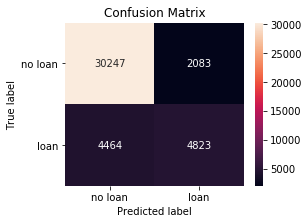

Accuracy:  0.8426844799000408
Sensitivity (Recall):  0.5193280930332723 , Specificity (1-FPR):  0.9355706773894216
Precision:  0.1375249500998004 , F1-Score:  0.21746285817345629
AUC:  0.7274493852113469


In [70]:
predicted_test = dt.predict(X_test)

pred_test_dt = sklearn.metrics.confusion_matrix(
    Y_test, predicted_test > 0.5)
DrawConfusionMatrix(pred_test_dt)
SensitivityAndSpecificity(pred_test_dt)

print('AUC: ',roc_auc_score(Y_test, predicted_test > 0.5))

In [0]:
def youden(xtruedat,ytruedat, model):

  fpr, tpr, cutoffs = sklearn.metrics.roc_curve(
    ytruedat, model.predict(xtruedat))
  tnr = 1-fpr
  youdens_curve = tpr + tnr - 1
  youdens_index_argmax = youdens_curve.argmax()
  youdens_index_cutoff = cutoffs[youdens_index_argmax]
  youdens_curve = tpr - fpr
  print('Maximum Youden\'s Index: %f' % youdens_curve[youdens_index_argmax])
#   print('                Cutoff: %f' % youdens_index_cutoff)
  return youdens_curve[youdens_index_argmax]

# Clustering

Since the result of machine learning model from data without performing a customer segmentation beforehand does not give us much insight and is hard to interpret. We reduced some noise and tried to be more focused on a group of customers by conducting a clustering analysis using Kmean. The steps of clustering analysis are described as follow.

1. Convert categorical features into dummy binary variables
2. Drop features that are not related to a characteristic of customers such as  Outcome, Rate, Competitior Rate
3. Scaled data to make the range become 0 and 1 since clustering model is performed by minimizing the variation of euclidean distance of data among the same cluster. Data field that has bigger value like Amount could create a bias in the model  
4. Performed a PCA to reduce dimension of features
5. Find the best number of clusters by analyze the plot of the number of cluster VS. Root sum square error. We picked 9 since it is the elbow of the plot
6. Clustering!
7. Visualized result

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by the scale function.
  # This is added back by InteractiveShellApp.init_path()


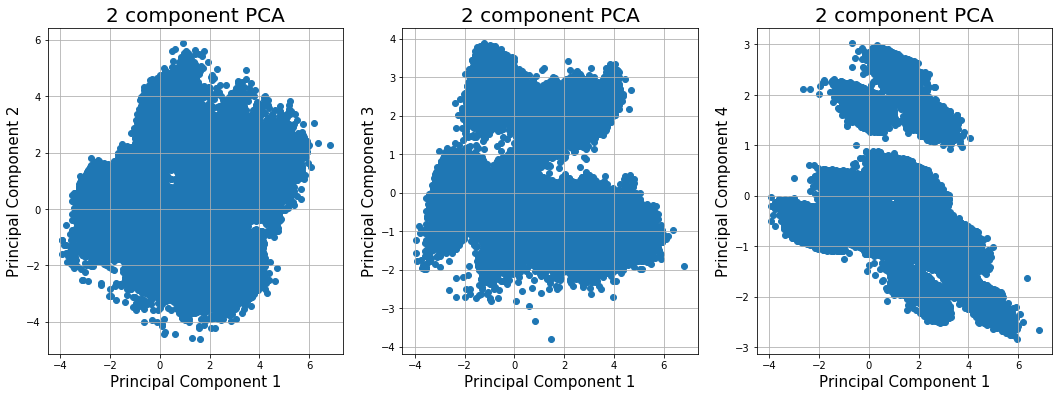

In [72]:
from sklearn.preprocessing import scale

from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing
from sklearn.decomposition import PCA

nomis_x = nomis.drop(['Outcome','Competition rate'],1) 
# drop outcome and rate. We want to group by factors that we cannot adjust. 
# I dropped Competition Rate since I want to segment only by the infomartion of customer

nomis_x_scale = preprocessing.scale(nomis_x)

# reduce dimension of data by PCA
# https://stats.stackexchange.com/questions/99171/why-is-euclidean-distance-not-a-good-metric-in-high-dimensions/
# cite this link as why we should do this
pca = PCA(n_components=4)
pca.fit(nomis_x_scale)
X_pca = pca.transform(nomis_x_scale)
principalDf = pd.DataFrame(data = X_pca, columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4'])
fig = plt.figure(2,figsize = (18,6))
ax = fig.add_subplot(1,3,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

ax.scatter(principalDf['principal component 1']
             , principalDf['principal component 2'])

ax.grid()
ax = fig.add_subplot(1,3,2) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

ax.scatter(principalDf['principal component 1']
             , principalDf['principal component 3'])

ax.grid()
ax = fig.add_subplot(1,3,3) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 4', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

ax.scatter(principalDf['principal component 1']
             , principalDf['principal component 4'])

ax.grid()

In [0]:
import numpy as np
clusters = np.array([1, 2, 3, 5, 7,9, 10,11, 15, 20, 25, 30])
errors   = {}


for cluster_index in range(len(clusters)):
  # Cluster the training fold
  n_clusters = clusters[cluster_index]
  km = sklearn.cluster.KMeans(
      n_clusters=n_clusters)
  km.fit(X=principalDf)
  errors[clusters[cluster_index]] = km.inertia_ 

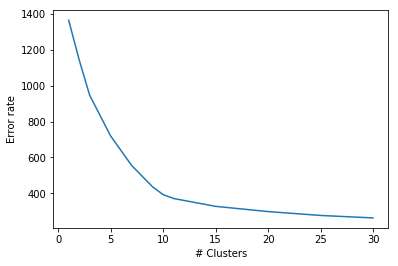

In [74]:
plt.plot(errors.keys(),[x**(1/2) for x in errors.values()])
plt.xlabel('# Clusters')
plt.ylabel('Error rate')
plt.show()

# we pick the best cluster by pick the point where there is an elbow in the curve. This concept is similar to cross validation.

In [0]:
n_clusters = 9
clusmodel = sklearn.cluster.KMeans(
      n_clusters=n_clusters, random_state = 7)

# clusmodel = AgglomerativeClustering(
#       n_clusters=n_clusters,affinity='cosine',linkage='')
clusmodel.fit(X=principalDf)
nomis_x['clusters'] = clusmodel.labels_

In [0]:
nomis_x['types'] = nomis_x[['N','R','U']].idxmax(axis=1)
nomis_x['tiers'] = nomis_x[[1,2,3,4]].idxmax(axis=1)

nomis_x = nomis_x.drop(['N','R','U',1,2,3,4],1)
nomis_x['Outcome'], nomis_x['Rate'] = nomis['Outcome'], nomis['Rate']

In [77]:
nomis_x.head()

,FICO,Term,Amount,Previous Rate,Rate,Cost of Funds,Partner Bin,clusters,types,tiers,Outcome
0,695,72,35000.00000000,0.00000000,7.49000000,1.83880000,1,3,N,3,0
1,751,60,40000.00000000,0.00000000,5.49000000,1.83880000,3,1,N,1,0
2,731,60,18064.00000000,0.00000000,5.49000000,1.83880000,3,1,N,1,0
3,652,72,15415.00000000,0.00000000,8.99000000,1.83880000,3,3,N,4,0
4,730,48,32000.00000000,0.00000000,5.49000000,1.83880000,1,1,N,1,0


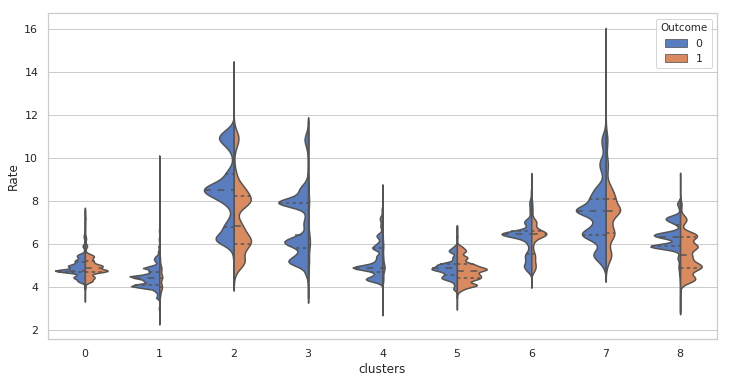

In [78]:
plt.figure(figsize=(12, 6))
import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.violinplot(x="clusters", y="Rate", hue="Outcome",
               split=True, inner="quartile", palette="muted",scale="count",
               data= nomis_x[['clusters','Outcome','Rate']] )

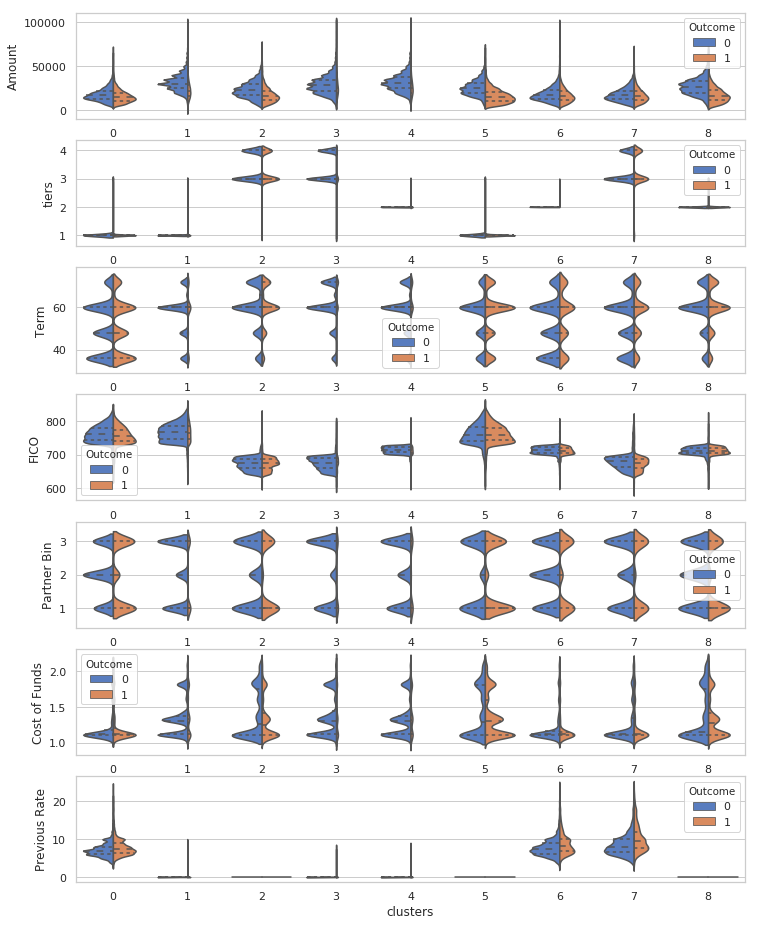

In [79]:
# see how customers fall into each cluster

fig, axes = plt.subplots(7,1,figsize=(12, 16))

sns.violinplot(x="clusters", y="Amount", hue="Outcome",
               split=True, inner="quartile", palette="muted",scale="count",
               data= nomis_x[['clusters','Outcome','Amount']],ax=axes[0]  )

sns.violinplot(x="clusters", y="tiers", hue="Outcome",
               split=True, inner="quartile", palette="muted",scale="count",
               data= nomis_x[['clusters','Outcome','tiers']],ax=axes[1] )
sns.violinplot(x="clusters", y="Term", hue="Outcome",
               split=True, inner="quartile", palette="muted",scale="count",
               data= nomis_x[['clusters','Outcome','Term']],ax=axes[2] )
sns.violinplot(x="clusters", y="FICO", hue="Outcome",
               split=True, inner="quartile", palette="muted",scale="count",
               data= nomis_x[['clusters','Outcome','FICO']],ax=axes[3] )
sns.violinplot(x="clusters", y="Partner Bin", hue="Outcome",
               split=True, inner="quartile", palette="muted",scale="count",
               data= nomis_x[['clusters','Outcome','Partner Bin']],ax=axes[4] )
sns.violinplot(x="clusters", y="Cost of Funds", hue="Outcome",
               split=True, inner="quartile", palette="muted",scale="count",
               data= nomis_x[['clusters','Outcome','Cost of Funds']],ax=axes[5] )
sns.violinplot(x="clusters", y="Previous Rate", hue="Outcome",
               split=True, inner="quartile", palette="muted",scale="count",
               data= nomis_x[['clusters','Outcome','Previous Rate']],ax=axes[6] )

In [0]:
nomis['cluster'] = nomis_x['clusters']

In [0]:
from sklearn.model_selection import train_test_split

nomis2 = nomis[nomis.cluster == 0]
X_train, X_test, Y_train, Y_test = train_test_split(nomis2.drop('Outcome',1), nomis2.Outcome, test_size=0.2)

In [0]:
from sklearn.model_selection import KFold

features = X_train.columns

def GetDecisionTreeGraphViz(dt):
  from IPython.display import Image
  return graphviz.Source(sklearn.tree.export_graphviz(
      dt, out_file=None, filled=True, impurity=False,
      feature_names=features,
      class_names=['no loan','loan']))

def getthebestdepth(dep):
  import numpy as np
  train_errors = np.zeros([dep, 5])
  valid_errors = np.zeros([dep, 5])
  # 5-fold cross validation
  kf = KFold(n_splits=5) 
  kf.get_n_splits(X_train)
  fold_index = 0
  for train_index, test_index in kf.split(X_train):
    X_training, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
    Y_training, Y_val = Y_train.iloc[train_index], Y_train.iloc[test_index]

    for d in range(1,dep+1):
#       print(d, fold_index)
      dt = sklearn.tree.DecisionTreeClassifier(max_depth=d,random_state=7)
      dt.fit(X_training, Y_training)
      train_errors[d-1, fold_index] = 1 - dt.score(X_training, Y_training)
      valid_errors[d-1, fold_index] = 1 - dt.score(X_val, Y_val)
    fold_index += 1
  mean_train_error = np.mean(train_errors,1)
  mean_valid_error = np.mean(valid_errors,1)
  plt.plot(range(1,dep+1), mean_train_error, label='Mean Training Error')
  plt.plot(range(1,dep+1), mean_valid_error, label='Mean Validation Error')
  plt.xlabel('Max Tree Depth')
  plt.ylabel('Error (higher is better)')
  plt.legend()
  plt.show()

### Cluster 0

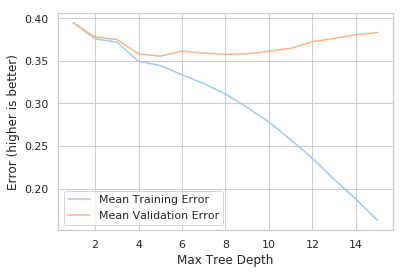

In [83]:
getthebestdepth(15)

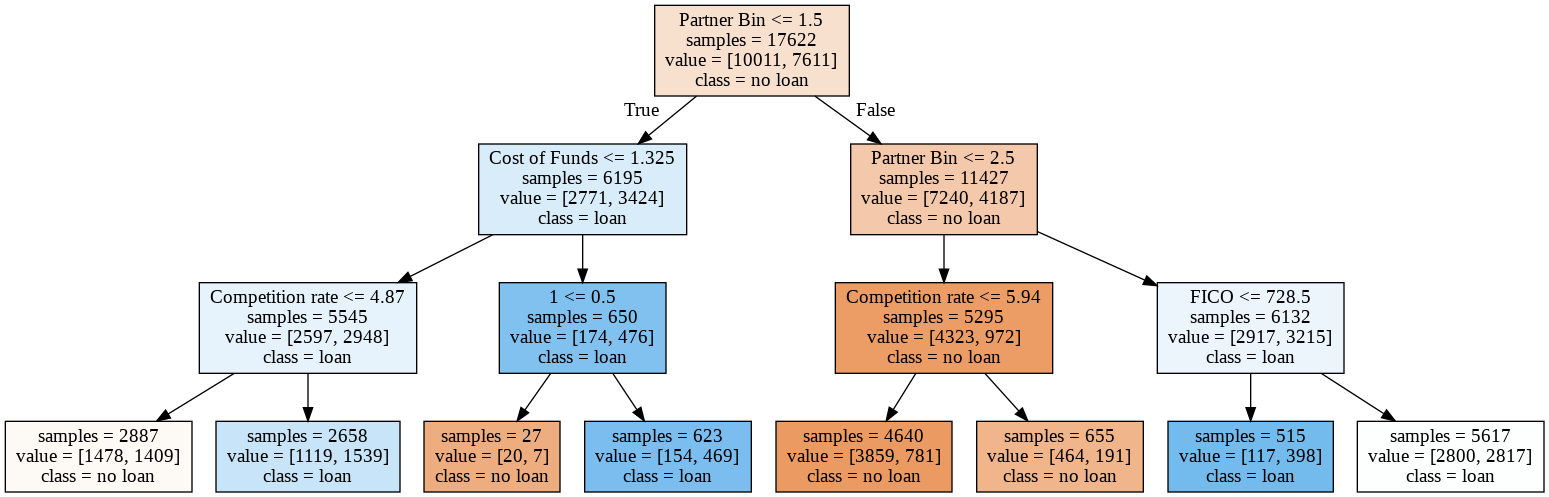

Maximum Youden's Index: 0.279188


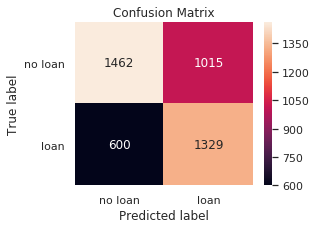

Accuracy:  0.6334543803903767
Sensitivity (Recall):  0.6889580093312597 , Specificity (1-FPR):  0.5902301170771094
Precision:  0.47617341454675743 , F1-Score:  0.5631355932203389


{'Sensitivity': 0.6889580093312597, 'Specificity': 0.5902301170771094}

In [84]:
dt = sklearn.tree.DecisionTreeClassifier(max_depth=3,random_state=7)
dt.fit(X_train, Y_train)
display(Image(GetDecisionTreeGraphViz(dt).pipe(format='png'), width=900))

you = youden(X_test, Y_test, dt)

predicted_test = dt.predict(X_test)

pred_test_dt = sklearn.metrics.confusion_matrix(
    Y_test, predicted_test > you)
DrawConfusionMatrix(pred_test_dt)
SensitivityAndSpecificity(pred_test_dt)

## Cluster 1

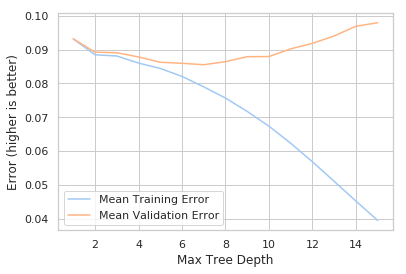

In [85]:
nomisclus = nomis[nomis.cluster == 1]
X_train, X_test, Y_train, Y_test = train_test_split(nomisclus.drop('Outcome',1), nomisclus.Outcome, test_size=0.2)
getthebestdepth(15)

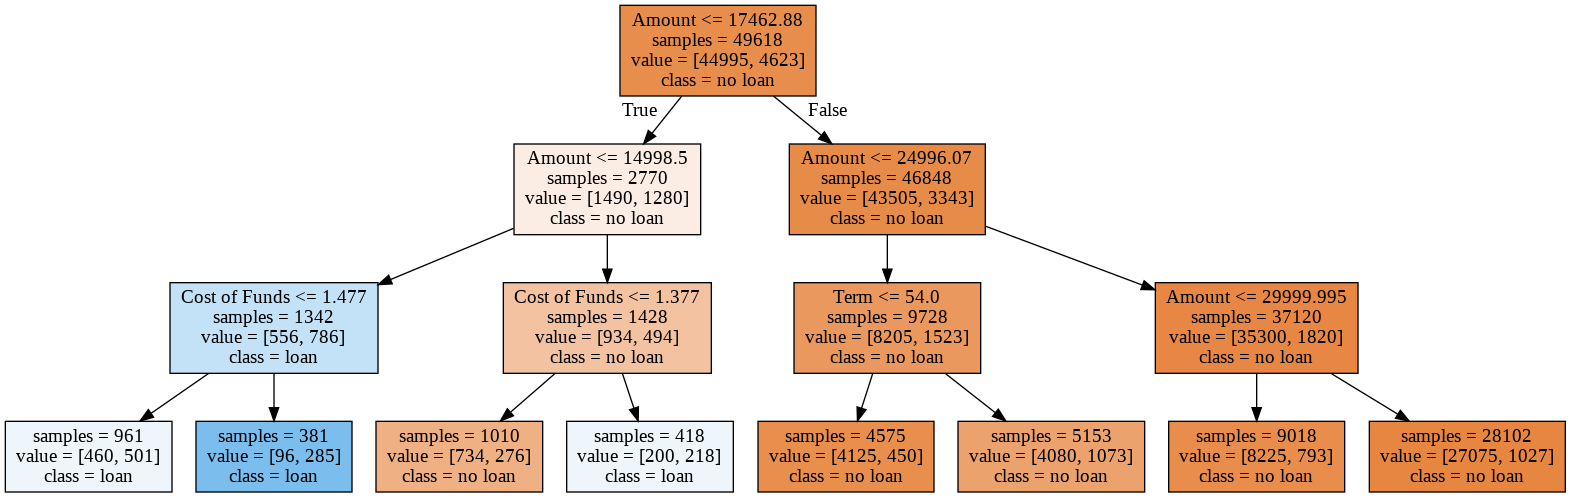

Maximum Youden's Index: 0.208064


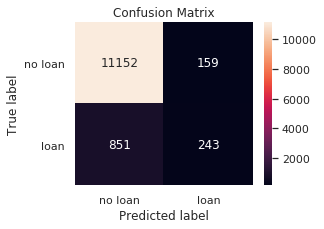

Accuracy:  0.9185812172511084
Sensitivity (Recall):  0.22212065813528337 , Specificity (1-FPR):  0.9859428874546902
Precision:  0.02132514260640632 , F1-Score:  0.03891424453519096


{'Sensitivity': 0.22212065813528337, 'Specificity': 0.9859428874546902}

In [86]:
dt = sklearn.tree.DecisionTreeClassifier(max_depth=3,random_state=7)
dt.fit(X_train, Y_train)
display(Image(GetDecisionTreeGraphViz(dt).pipe(format='png'), width=1200))
you = youden(X_test, Y_test, dt)

predicted_test = dt.predict(X_test)

pred_test_dt = sklearn.metrics.confusion_matrix(
    Y_test, predicted_test > you)
DrawConfusionMatrix(pred_test_dt)
SensitivityAndSpecificity(pred_test_dt)

## Cluster 2

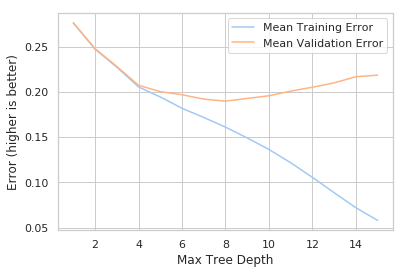

In [87]:
nomisclus = nomis[nomis.cluster == 2]
X_train, X_test, Y_train, Y_test = train_test_split(nomisclus.drop('Outcome',1), nomisclus.Outcome, test_size=0.2)
getthebestdepth(15)

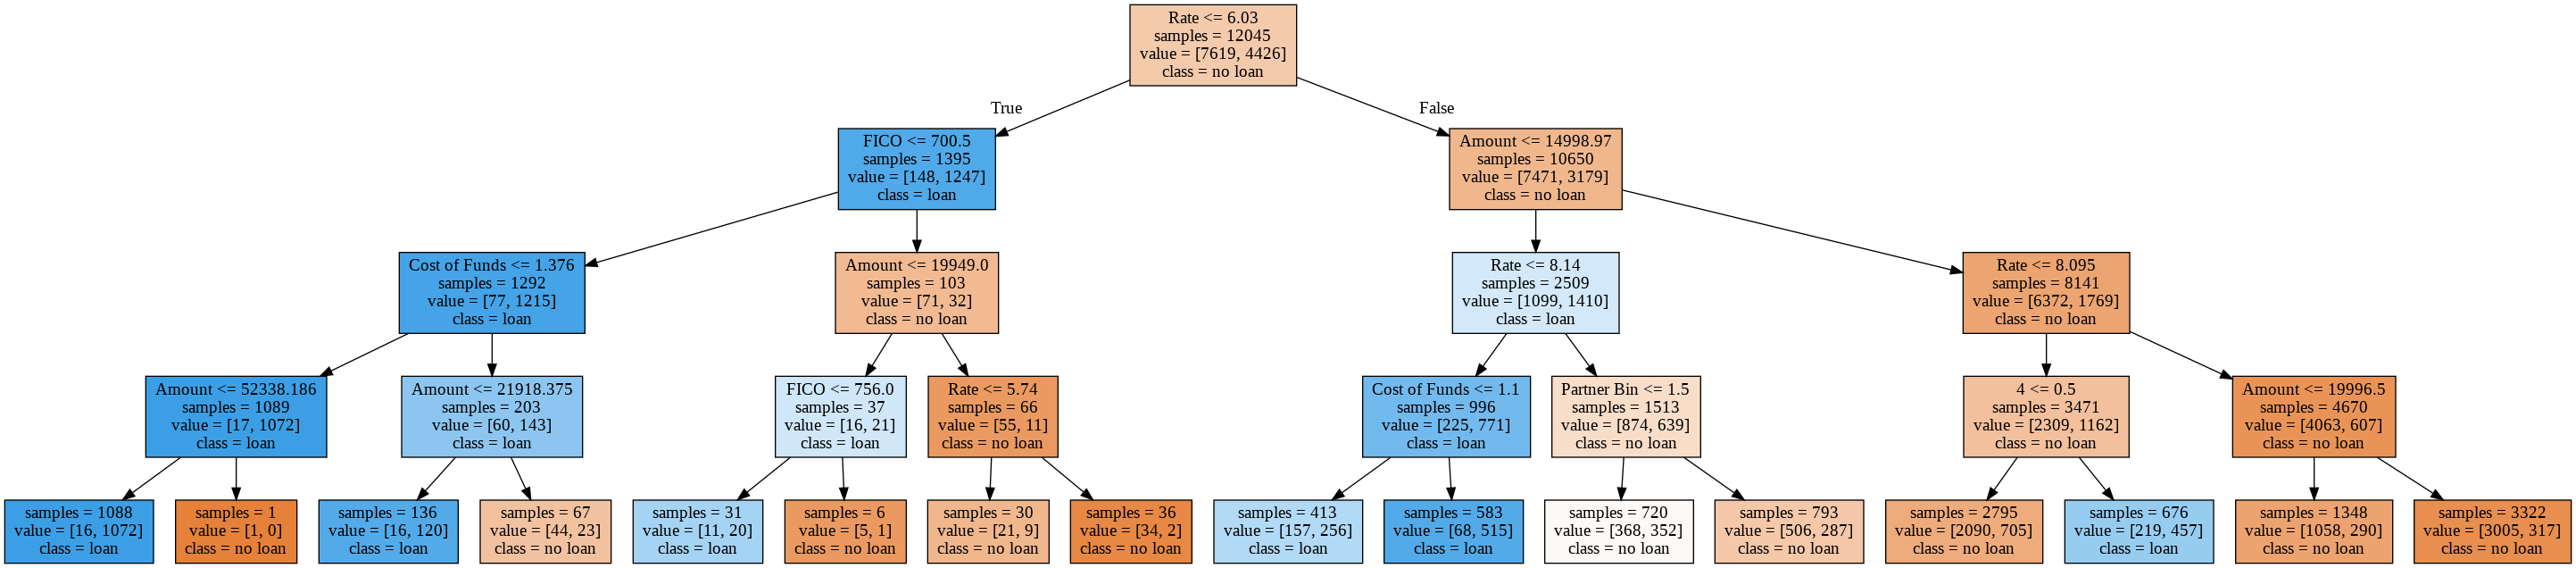

Maximum Youden's Index: 0.469496


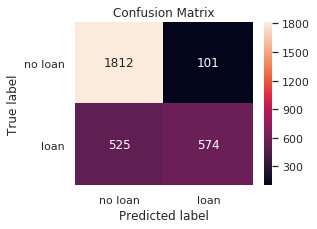

Accuracy:  0.7921646746347941
Sensitivity (Recall):  0.5222929936305732 , Specificity (1-FPR):  0.9472033455305803
Precision:  0.24056999161777032 , F1-Score:  0.32941176470588235


{'Sensitivity': 0.5222929936305732, 'Specificity': 0.9472033455305803}

In [88]:
dt = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=7)
dt.fit(X_train, Y_train)
display(Image(GetDecisionTreeGraphViz(dt).pipe(format='png'), width=900))

you = youden(X_test, Y_test, dt)

predicted_test = dt.predict(X_test)

pred_test_dt = sklearn.metrics.confusion_matrix(
    Y_test, predicted_test > you)
DrawConfusionMatrix(pred_test_dt)
SensitivityAndSpecificity(pred_test_dt)

## Cluster 3

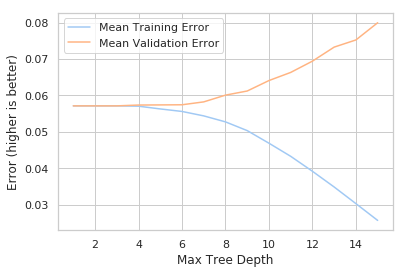

In [89]:
nomisclus = nomis[nomis.cluster == 3]
X_train, X_test, Y_train, Y_test = train_test_split(nomisclus.drop('Outcome',1), nomisclus.Outcome, test_size=0.2)
getthebestdepth(15)

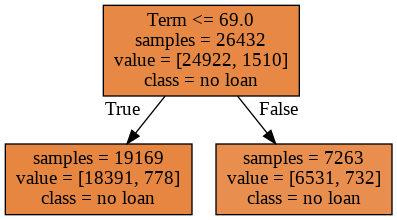

Maximum Youden's Index: 0.000000


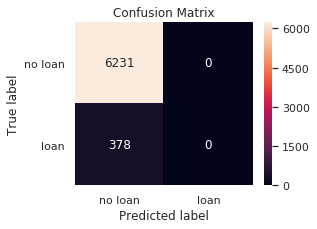

Accuracy:  0.9428052655469814
Sensitivity (Recall):  0.0 , Specificity (1-FPR):  1.0
Precision:  0.0 , F1-Score:  nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


{'Sensitivity': 0.0, 'Specificity': 1.0}

In [90]:
dt = sklearn.tree.DecisionTreeClassifier(max_depth=1,random_state=7)
dt.fit(X_train, Y_train)
display(Image(GetDecisionTreeGraphViz(dt).pipe(format='png'), width=600))

you = youden(X_test, Y_test, dt)

predicted_test = dt.predict(X_test)

pred_test_dt = sklearn.metrics.confusion_matrix(
    Y_test, predicted_test > you)
DrawConfusionMatrix(pred_test_dt)
SensitivityAndSpecificity(pred_test_dt)

## Cluster 4

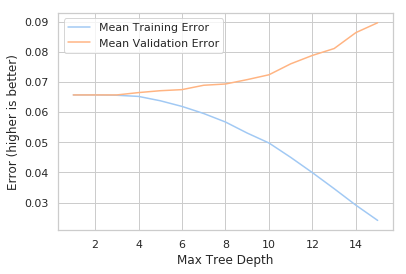

In [91]:
nomisclus = nomis[nomis.cluster == 4]
X_train, X_test, Y_train, Y_test = train_test_split(nomisclus.drop('Outcome',1), nomisclus.Outcome, test_size=0.2)
getthebestdepth(15)

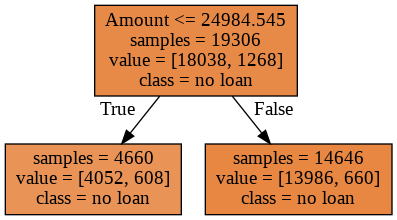

Maximum Youden's Index: 0.000000


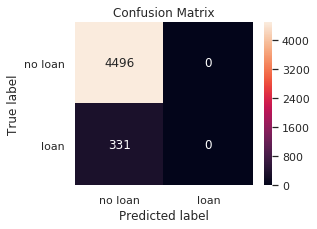

Accuracy:  0.9314273876113528
Sensitivity (Recall):  0.0 , Specificity (1-FPR):  1.0
Precision:  0.0 , F1-Score:  nan


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars


{'Sensitivity': 0.0, 'Specificity': 1.0}

In [92]:
dt = sklearn.tree.DecisionTreeClassifier(max_depth=1,random_state=3) 
dt.fit(X_train, Y_train)
display(Image(GetDecisionTreeGraphViz(dt).pipe(format='png'), width=300))
you = youden(X_test, Y_test, dt)

predicted_test = dt.predict(X_test)

pred_test_dt = sklearn.metrics.confusion_matrix(
    Y_test, predicted_test > you)
DrawConfusionMatrix(pred_test_dt)
SensitivityAndSpecificity(pred_test_dt)

## Cluster 5

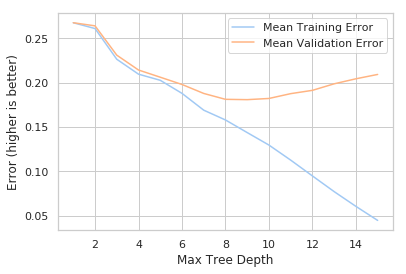

In [93]:
nomisclus = nomis[nomis.cluster == 5]
X_train, X_test, Y_train, Y_test = train_test_split(nomisclus.drop('Outcome',1), nomisclus.Outcome, test_size=0.2)
getthebestdepth(15)

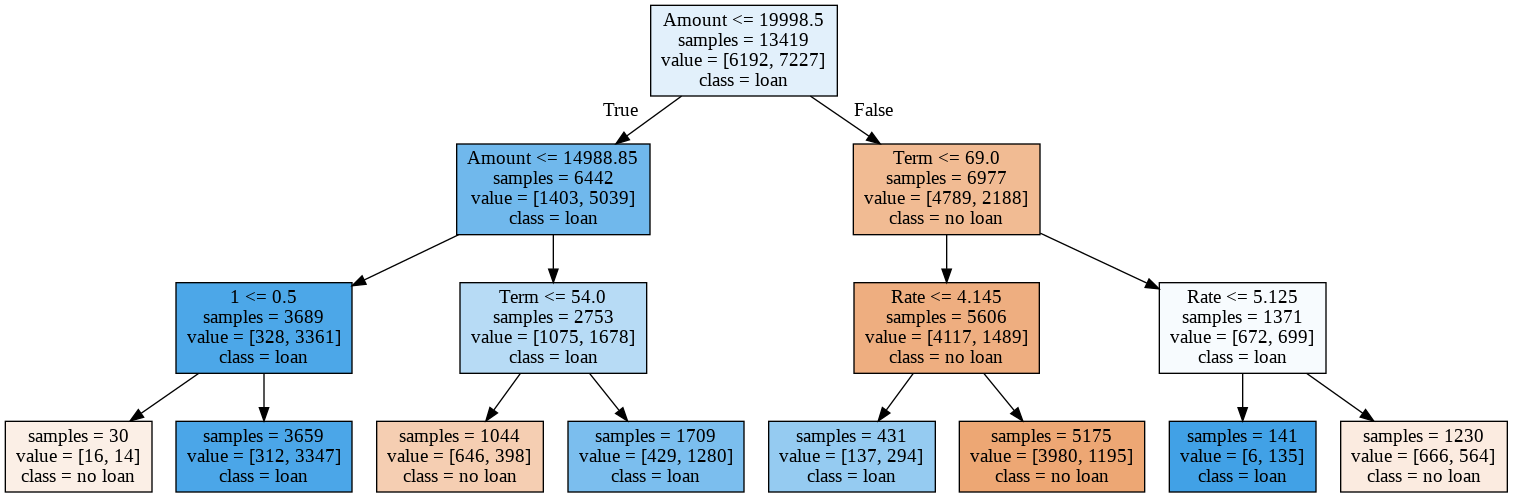

Maximum Youden's Index: 0.549232


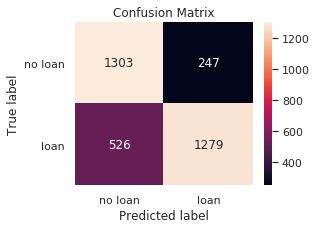

Accuracy:  0.7695976154992549
Sensitivity (Recall):  0.7085872576177286 , Specificity (1-FPR):  0.8406451612903226
Precision:  0.4953524399690163 , F1-Score:  0.5830863916115797


{'Sensitivity': 0.7085872576177286, 'Specificity': 0.8406451612903226}

In [94]:
dt = sklearn.tree.DecisionTreeClassifier(max_depth=3,random_state=7) 
dt.fit(X_train, Y_train)
display(Image(GetDecisionTreeGraphViz(dt).pipe(format='png'), width=1000))

you = youden(X_test, Y_test, dt)

predicted_test = dt.predict(X_test)

pred_test_dt = sklearn.metrics.confusion_matrix(
    Y_test, predicted_test > you)
DrawConfusionMatrix(pred_test_dt)
SensitivityAndSpecificity(pred_test_dt)

## Cluster 6

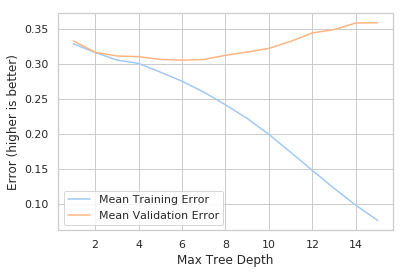

In [95]:
nomisclus = nomis[nomis.cluster == 6]
X_train, X_test, Y_train, Y_test = train_test_split(nomisclus.drop('Outcome',1), nomisclus.Outcome, test_size=0.2)
getthebestdepth(15)

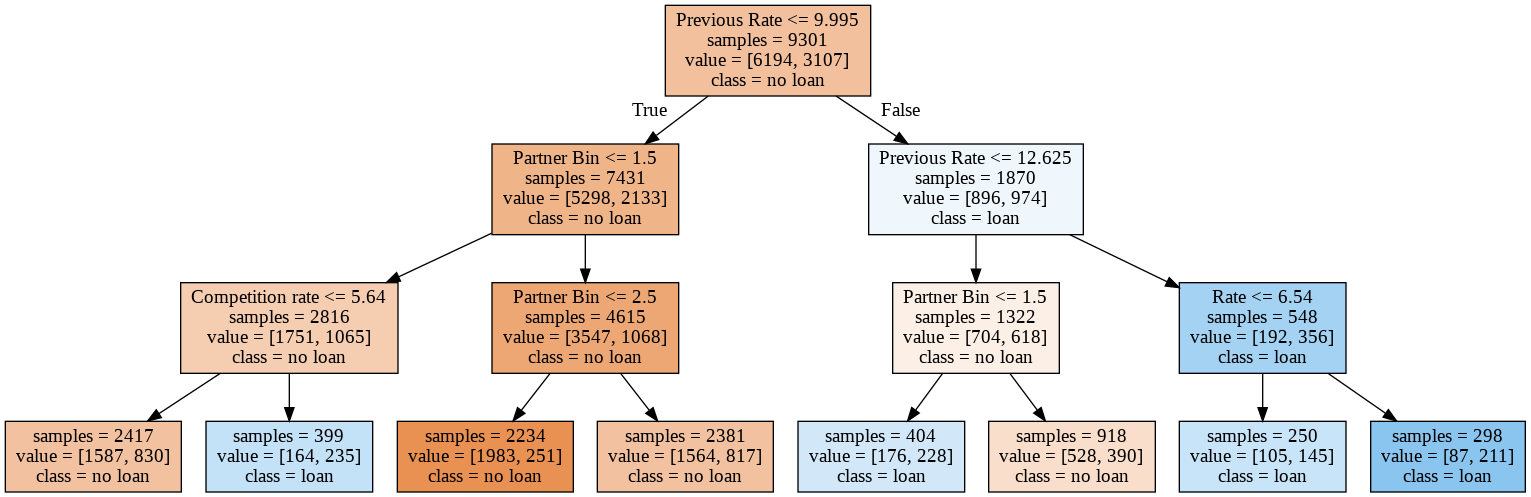

Maximum Youden's Index: 0.159484


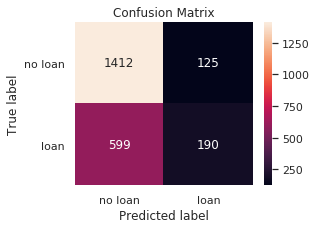

Accuracy:  0.6887360275150473
Sensitivity (Recall):  0.24081115335868186 , Specificity (1-FPR):  0.9186727391021471
Precision:  0.11860174781523096 , F1-Score:  0.1589293182768716


{'Sensitivity': 0.24081115335868186, 'Specificity': 0.9186727391021471}

In [96]:
dt = sklearn.tree.DecisionTreeClassifier(max_depth=3,random_state=3) 
dt.fit(X_train, Y_train)
display(Image(GetDecisionTreeGraphViz(dt).pipe(format='png'), width=1000))

you = youden(X_test, Y_test, dt)

predicted_test = dt.predict(X_test)

pred_test_dt = sklearn.metrics.confusion_matrix(
    Y_test, predicted_test > you)
DrawConfusionMatrix(pred_test_dt)
SensitivityAndSpecificity(pred_test_dt)

## Cluster 7

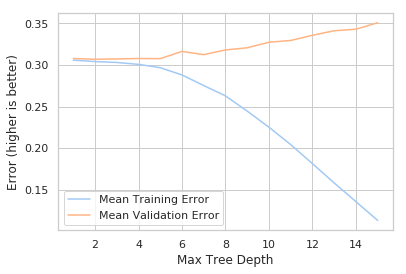

In [97]:
nomisclus = nomis[nomis.cluster == 7]
X_train, X_test, Y_train, Y_test = train_test_split(nomisclus.drop('Outcome',1), nomisclus.Outcome, test_size=0.2)
getthebestdepth(15)

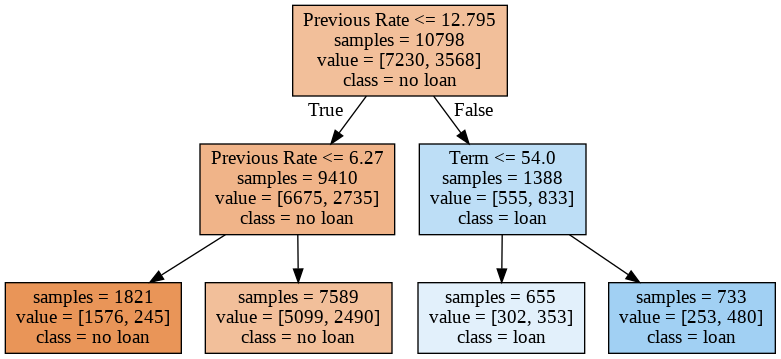

Maximum Youden's Index: 0.143289


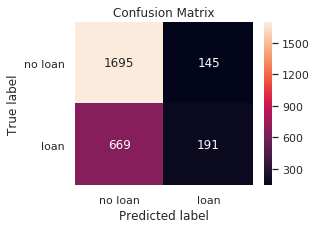

Accuracy:  0.6985185185185185
Sensitivity (Recall):  0.22209302325581395 , Specificity (1-FPR):  0.9211956521739131
Precision:  0.10127253446447508 , F1-Score:  0.13911143481427532


{'Sensitivity': 0.22209302325581395, 'Specificity': 0.9211956521739131}

In [98]:
dt = sklearn.tree.DecisionTreeClassifier(max_depth=2,random_state=3) 
dt.fit(X_train, Y_train)
display(Image(GetDecisionTreeGraphViz(dt).pipe(format='png'), width=600))
you = youden(X_test, Y_test, dt)

predicted_test = dt.predict(X_test)

pred_test_dt = sklearn.metrics.confusion_matrix(
    Y_test, predicted_test > you)
DrawConfusionMatrix(pred_test_dt)
SensitivityAndSpecificity(pred_test_dt)

## Cluster 8

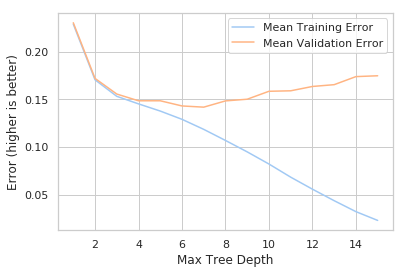

In [99]:
nomisclus = nomis[nomis.cluster == 8]
X_train, X_test, Y_train, Y_test = train_test_split(nomisclus.drop('Outcome',1), nomisclus.Outcome, test_size=0.2)
getthebestdepth(15)

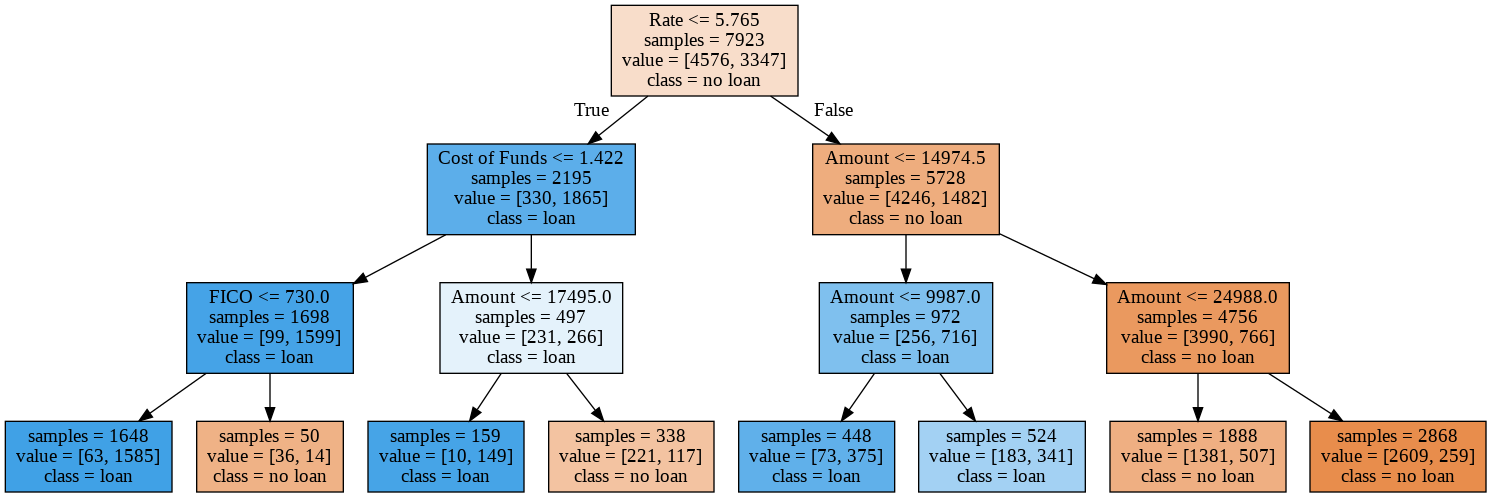

Maximum Youden's Index: 0.662202


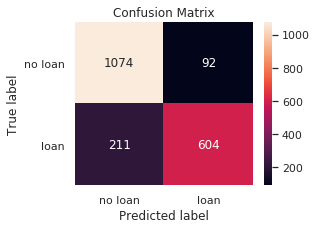

Accuracy:  0.8470469459868754
Sensitivity (Recall):  0.7411042944785277 , Specificity (1-FPR):  0.9210977701543739
Precision:  0.3599523241954708 , F1-Score:  0.48455675892498995


{'Sensitivity': 0.7411042944785277, 'Specificity': 0.9210977701543739}

In [100]:
dt = sklearn.tree.DecisionTreeClassifier(max_depth=3,random_state=3) 
dt.fit(X_train, Y_train)
display(Image(GetDecisionTreeGraphViz(dt).pipe(format='png'), width=900))

you = youden(X_test, Y_test, dt)

predicted_test = dt.predict(X_test)

pred_test_dt = sklearn.metrics.confusion_matrix(
    Y_test, predicted_test > you)
DrawConfusionMatrix(pred_test_dt)
SensitivityAndSpecificity(pred_test_dt)